In [5]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import Window
import pyspark.sql.functions as func

import logging
logging.getLogger("org.apache.spark").setLevel(logging.ERROR)

conf = (pyspark.SparkConf().setMaster("local")
        .set("spark.executor.memory", "2g")
        .set("spark.driver.memory", "1g")
        .set("spark.executor.cores", "3")
        .set("spark.default.parallelism", "12")
        .set("spark.sql.shuffle.partitions", "12"))

# Initialize a Spark session
spark = SparkSession.builder \
    .appName("Assign3 Data Analysis") \
    .config(conf=conf) \
    .getOrCreate()

24/03/28 00:07:39 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [10]:
# Create an RDD from a CSV file
df = spark.read.csv("/Users/wilfried/Downloads/amzon_products_data_processed.csv", sep="|", header=True, inferSchema=True)
print("Overview")
# show schema of the dataframe
print("Num of rows: ", df.count())
df.printSchema()
# drop duplicate rows
df = df.dropDuplicates(["product_id"])
df.show()

Overview
root
 |-- product_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- imgUrl: string (nullable = true)
 |-- productURL: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- reviews: integer (nullable = true)
 |-- price: double (nullable = true)
 |-- listPrice: double (nullable = true)
 |-- categoryName: string (nullable = true)
 |-- isBestSeller: boolean (nullable = true)
 |-- boughtInLastMonth: integer (nullable = true)


+----------+--------------------+------+----------+-----+-------+-----+---------+--------------------+------------+-----------------+
|product_id|               title|imgUrl|productURL|stars|reviews|price|listPrice|        categoryName|isBestSeller|boughtInLastMonth|
+----------+--------------------+------+----------+-----+-------+-----+---------+--------------------+------------+-----------------+
|0399255370|The Day the Crayo...|  NULL|      NULL|  4.8|  22203| 23.5|      0.0|Arts Crafts Supplies|       false|                0|
|0486256278|Années de Pèlerin...|  NULL|      NULL|  4.6|     37|26.33|      0.0|     Perfume Cologne|       false|                0|
|0486403106|      Train Stickers|  NULL|      NULL|  4.3|   1605| 3.25|      0.0|Arts Crafts Supplies|       false|                0|
|0486403149|Alice in Wonderla...|  NULL|      NULL|  4.3|    233|  0.0|      0.0|Arts Crafts Supplies|       false|                0|
|048648243X|Build Your Own Cu...|  NULL|      NULL|  3.7|   50

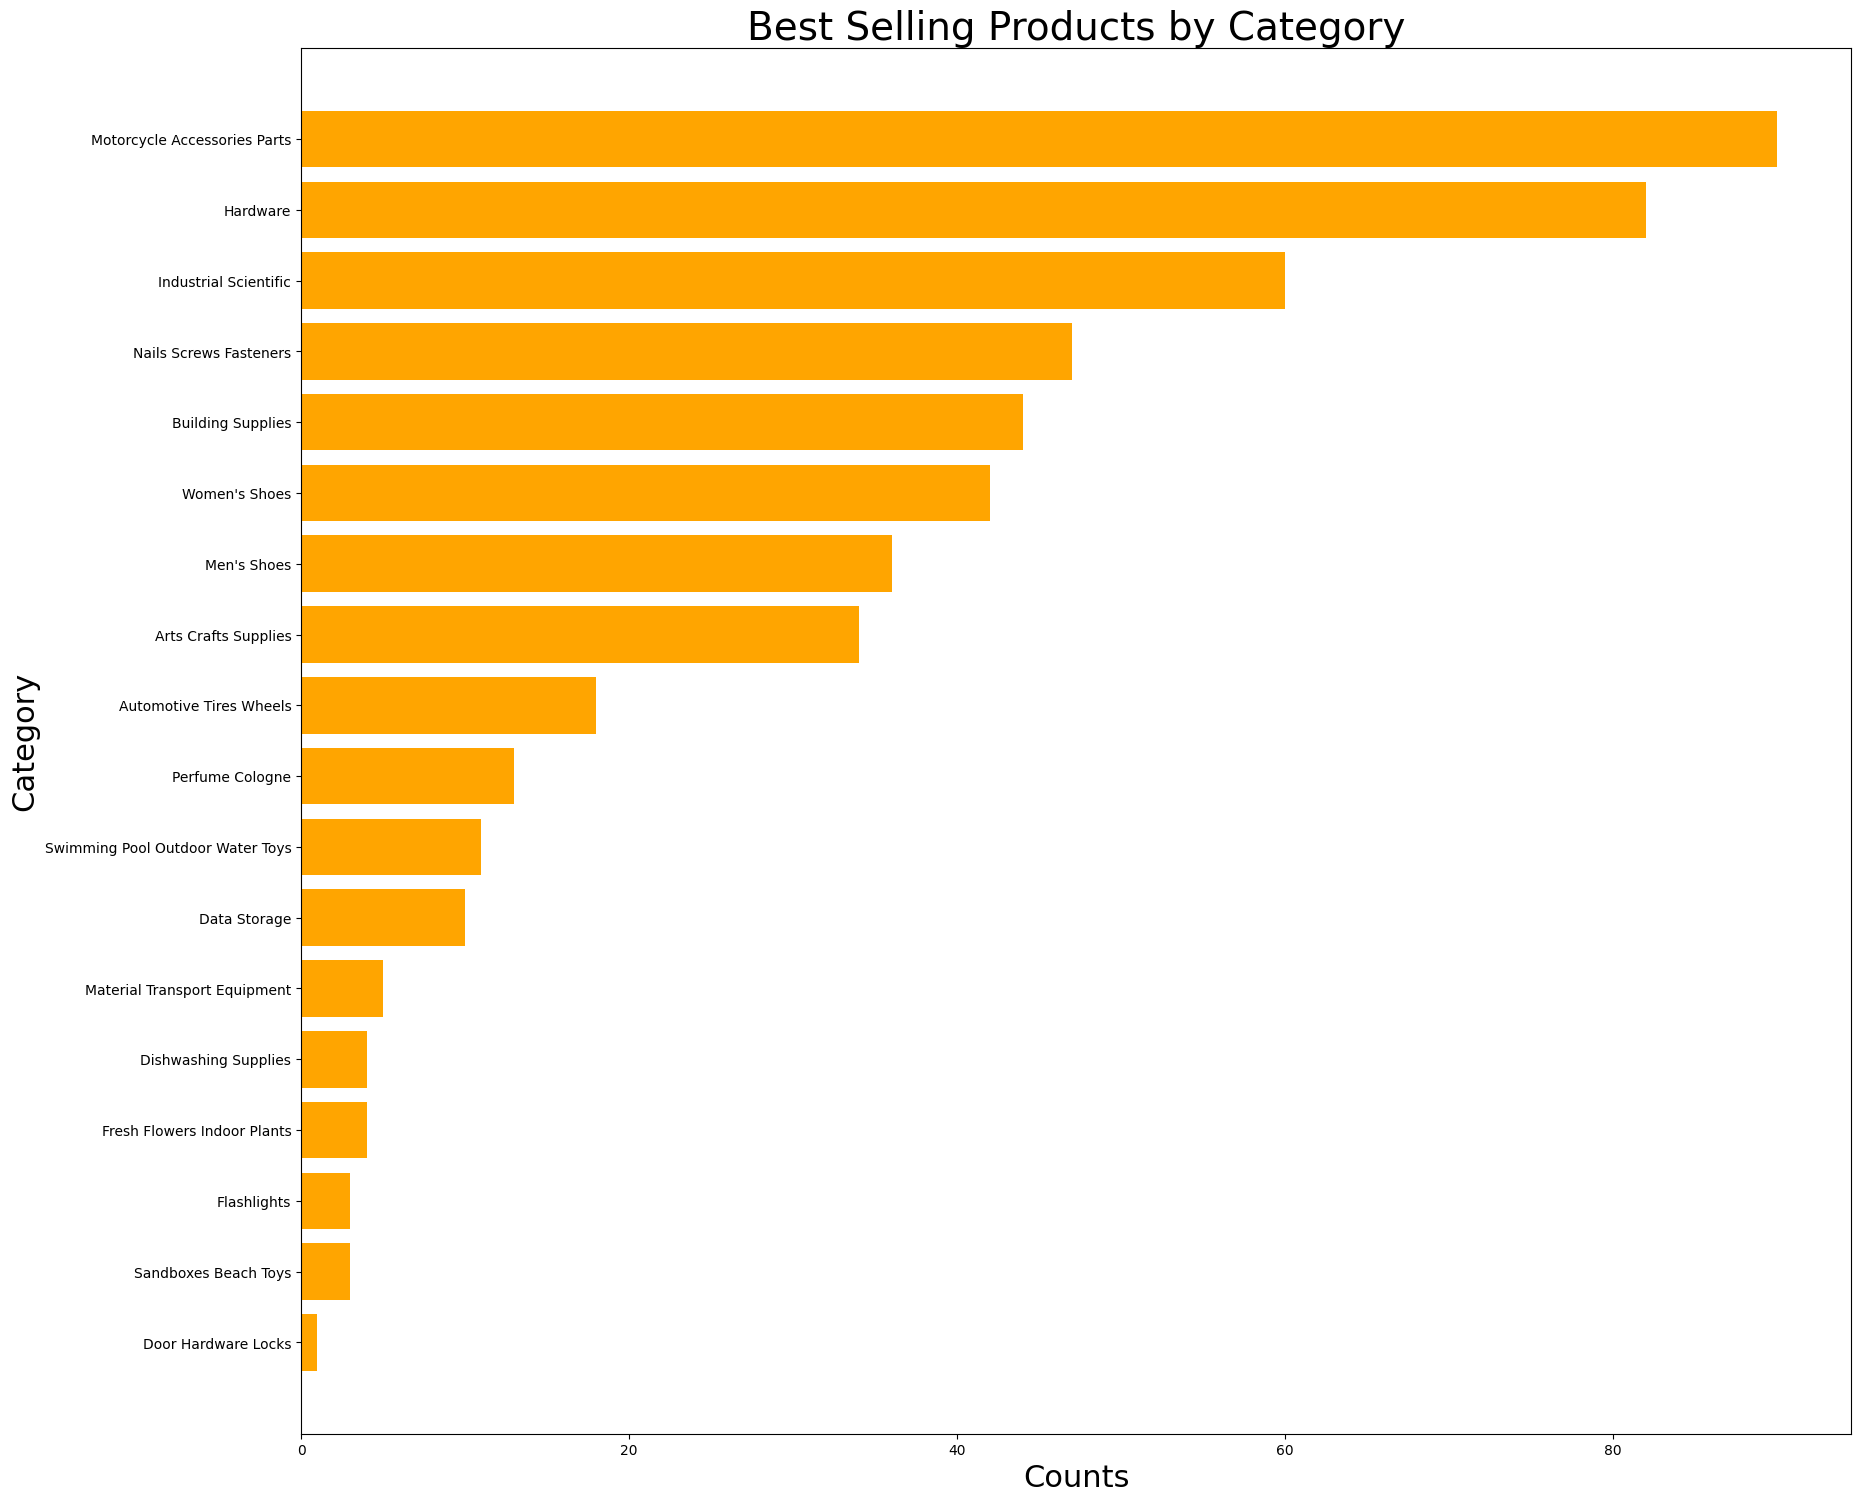

In [11]:
from pyspark.sql.functions import regexp_replace

df = df.fillna("Others", subset=["categoryName"])
df = df.fillna(99999.0, subset=["listPrice", "price"])
df = df.fillna("False", subset=["isBestSeller"])
df = df.fillna(0, subset=["reviews"])
df = df.fillna("0.0", subset=["stars"])
df = df.filter(func.col("stars").cast("double").isNotNull())

# count how many best selling products there are for each category
best_seller_df = df.filter(df.isBestSeller == True) \
    .groupBy(df.categoryName) \
    .count() \
    .orderBy("count", ascending=False)    

import pandas as pd
import matplotlib.pyplot as plt
categories = [row['categoryName'] for row in best_seller_df.collect()]
counts = [row['count'] for row in best_seller_df.collect()]
plt.figure(figsize=(20, 18))
plt.barh(categories, counts, color='orange')
plt.xlabel('Counts', fontsize=22)
plt.ylabel('Category', fontsize=22)
plt.title('Best Selling Products by Category', fontsize=28)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.show()

In [12]:
print(best_seller_df.count())
best_seller_df.show()

195207


18


+--------------------+-----+
|        categoryName|count|
+--------------------+-----+
|Motorcycle Access...|   90|
|            Hardware|   82|
|Industrial Scient...|   60|
|Nails Screws Fast...|   47|
|   Building Supplies|   44|
|       Women's Shoes|   42|
|         Men's Shoes|   36|
|Arts Crafts Supplies|   34|
|Automotive Tires ...|   18|
|     Perfume Cologne|   13|
|Swimming Pool Out...|   11|
|        Data Storage|   10|
|Material Transpor...|    5|
|Dishwashing Supplies|    4|
|Fresh Flowers Ind...|    4|
|         Flashlights|    3|
|Sandboxes Beach Toys|    3|
| Door Hardware Locks|    1|
+--------------------+-----+


In [13]:
# Define window specification partitioned by categoryName and ordered by stars and reviews
self_defined_window = Window.partitionBy("categoryName") \
                   .orderBy(func.desc("stars"), func.desc("reviews"))

# Assign rank to each product within its category
self_defined_ranked_df = df.withColumn("rank", func.row_number().over(self_defined_window))

# Select top 3 products based on their stars and reviews for each category
top_3_product_df = self_defined_ranked_df.filter(func.col("rank") <= 3) \
                              .select("product_id", "rank", "categoryName", "stars", "reviews")
top_3_product_df.show(top_3_product_df.count())

+----------+----+--------------------+-----+-------+
|product_id|rank|        categoryName|stars|reviews|
+----------+----+--------------------+-----+-------+
|B08KC6H2HW|   1|Arts Crafts Supplies|  5.0|     37|
|B09QB5715Y|   2|Arts Crafts Supplies|  5.0|     33|
|B08JWYDVTL|   3|Arts Crafts Supplies|  5.0|     30|
|B0C3L1MD4Z|   1|Automotive Tires ...|  5.0|     97|
|B07BQG51GJ|   2|Automotive Tires ...|  5.0|     31|
|B07JLJ5FSD|   3|Automotive Tires ...|  5.0|     29|
|B096T57LZN|   1|   Building Supplies|  5.0|     25|
|B0BZDTFKJZ|   2|   Building Supplies|  5.0|     20|
|B08WX41R36|   3|   Building Supplies|  5.0|     19|
|B09H1D7Y93|   1|        Data Storage|  5.0|     27|
|B08B4GLM2B|   2|        Data Storage|  5.0|     19|
|B0C9213GBX|   3|        Data Storage|  5.0|     18|
|B0B23V51TV|   1|Digital Media Dev...|  5.0|      5|
|B0BNCHDWZ9|   2|Digital Media Dev...|  5.0|      4|
|B0BC8R3Y1T|   3|Digital Media Dev...|  5.0|      3|
|B01GPWHW02|   1|Dishwashing Supplies|  5.0|  

In [17]:
# Based on 'stars', 'reviews', 'price', 'list price', we calculate the cost-efficiency of products of each category and find out the top 2 cost-efficient products with non-zero efficiency score.
price_to_perf_ratio_df = df.withColumn("efficiency_score", ((func.col("stars") * 0.3 + func.col("reviews") * 0.3 + (func.col("price") * 0.1 + func.col("listPrice")* 0.3)) / func.col("listPrice")))
self_defined_window2 = Window.partitionBy("categoryName").orderBy(func.desc("efficiency_score"))
ranked_df = price_to_perf_ratio_df.withColumn("efficiency_score_rank", func.rank().over(self_defined_window2))
top2_ranked_product_df = ranked_df.filter((func.col("efficiency_score_rank") <= 2) & (func.col("efficiency_score") > 0))

result_df = top2_ranked_product_df.select("product_id", "categoryName", "listPrice", "price", "stars", "reviews", "efficiency_score", "efficiency_score_rank")
result_df.show(result_df.count())

+----------+--------------------+---------+------+-----+-------+-------------------+---------------------+
|product_id|        categoryName|listPrice| price|stars|reviews|   efficiency_score|efficiency_score_rank|
+----------+--------------------+---------+------+-----+-------+-------------------+---------------------+
|B01BF6F20K|Arts Crafts Supplies|    14.99| 11.99|  4.7|  26966|  540.1538358905937|                    1|
|B00EJAEUBC|Arts Crafts Supplies|    11.99| 10.83|  4.6|  17946|  449.5296080066723|                    2|
|B07TVXP7FF|Automotive Tires ...|     8.99|  7.99|  4.2|  13002|  434.4111234705228|                    1|
|B07QR4Q42L|Automotive Tires ...|    59.99| 41.99|  4.4|  71183| 356.36632772128684|                    2|
|B07QC7JRDP|   Building Supplies|     9.64|   7.0|  4.2|  18570|  578.4078838174273|                    1|
|B074TWKVQB|   Building Supplies|    38.66| 23.99|  4.3|  69139|  536.9112002069323|                    2|
|B00KYK2AKO|        Data Storage|    

In [18]:
# Stop the Spark session
spark.stop()